<a href="https://colab.research.google.com/github/maestroK/machine_learning/blob/main/Machine_Learning_with_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basics

jax is very similar to numpy and jax code is accelarator agnostic.

In [2]:
import jax.numpy as jnp
import numpy as np

from jax import grad, jit, vmap, pmap

from jax import lax
from jax import make_jaxpr
from jax import random
from jax import device_put
import matplotlib.pyplot as plt

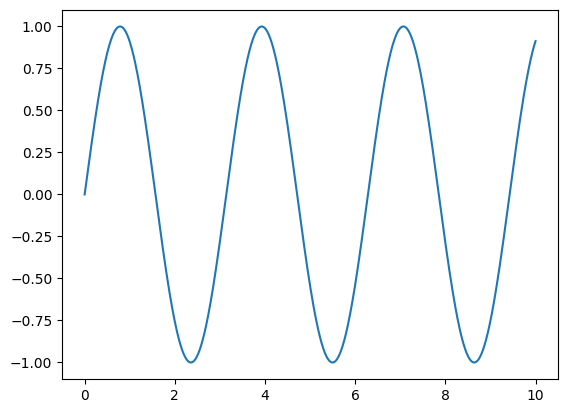

In [3]:
# example to illustrate jnp similarity to np

x_np = np.linspace(0,10,1000)
y_np = 2 * np.sin(x_np) * np.cos(x_np)
plt.plot(x_np,y_np)

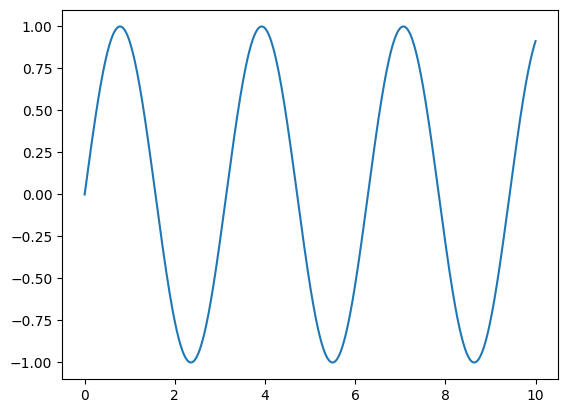

In [4]:
# all we need to do is change np with jnp
x_jnp = jnp.linspace(0,10,1000)
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)
plt.plot(x_jnp,y_jnp)

In [5]:
# JAX arrays are immutable unlike numpy, but you can change value by assiging new variable

size = 10
index = 0
value = 23

x = jnp.arange(size)
y = x.at[index].set(value)
print(x)
print(y)


[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]


In [6]:
# JAX handles random numbers differently than numpy

seed = 0
key = random.PRNGKey(seed)

x = random.normal(key, (10,))
print(type(x),x)

<class 'jaxlib.xla_extension.ArrayImpl'> [-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]


In [7]:
# JAX code is accelarator agnostic! Same code runs everywhere, no need to to from device to

size = 3000

# Data runs on whichever device is available, is pushed to ai accelarator if avilable
# No need to do .to(device) from PyTorch

x_jnp = random.normal(key,(size,size), dtype=jnp.float32)
x_np = np.random.normal(size=(size, size)).astype(np.float32)

%timeit jnp.dot(x_jnp, x_jnp.T).block_until_ready() # on GPU
%timeit np.dot(x_np, x_np.T) # on CPU
%timeit jnp.dot(x_np, x_np.T).block_until_ready() # On GPU with transfer overhead

x_np_device = device_put(x_np) # push np to gpu
%timeit jnp.dot(x_np_device, x_np_device.T).block_until_ready()


12.2 ms ± 463 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
464 ms ± 33.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
51.4 ms ± 1.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
12.9 ms ± 62.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# JAX Transform Functions

## jit()

jit compiles(turn into machine code) our function and caches(a supplementary memory from which speedy retrieval is possible) them using XLA which makes the program run faster.

In [8]:
def visualize_fn(fn, l=-10, r=10,n=1000):
  x = np.linspace(l,r,num=n)
  y=fn(x)
  plt.plot(x,y);plt.show()

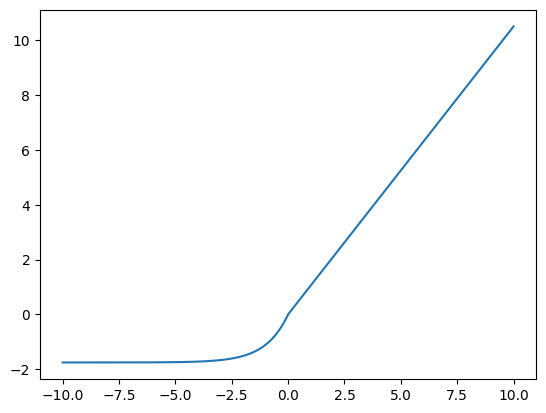

non-jit version: 
1.1 ms ± 147 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
jit version:
162 µs ± 19.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [9]:
def selu(x, alpha=1.67, lmbda=1.05):
  return lmbda * jnp.where(x>0, x, alpha * jnp.exp(x)-alpha)

selu_jit = jit(selu)

visualize_fn(selu) # using fn defined above

# benchmarking jit vs nonjit version

data = random.normal(key, (1000000,))

print("non-jit version: ")
%timeit selu(data).block_until_ready()
print('jit version:')
%timeit selu_jit(data).block_until_ready()

## grad()

In [15]:
# automatic diff

def sum_logistic(x):
  return jnp.sum(1.0/(1.0+jnp.exp(-x)))

x = jnp.arange(3.) # generate three random numbers
print(x)
loss = sum_logistic


# grad() calc deri wrt 1st parameter
grad_loss = grad(loss)

print(grad_loss(x))

[0. 1. 2.]
[0.25       0.19661194 0.10499357]


grad(loss) calculates the derivative of the function input, and then evaluates it for all values of x and stores the result as a list.

In [17]:
# let's take a different example

def sum(x):
  return jnp.sum(x**2)

x = jnp.arange(3.) # generate three random numbers
print(x)
loss = sum


# grad() calc deri wrt 1st parameter
grad_loss = grad(loss)

print(grad_loss(x))

[0. 1. 2.]
[0. 2. 4.]


### Jacobian and Hessian

Jacobian are matrices storing derivatives of multivariate functions

"In mathematics, the Hessian matrix, Hessian or (less commonly) Hesse matrix is a square matrix of second-order partial derivatives of a scalar-valued function, or scalar field. It describes the local curvature of a function of many variables. "

In [19]:
from jax import jacfwd, jacrev

f = lambda x,y: x**2 +y**2 # paraboloid

# df/dx = 2x, df/dy=2y, J = [df/dx, df/dy]

# d2f/dx = 2, d2f/dy = 2, H = [[d2f/dx, d2f/dxdy], [d2f/dydx, d2f/dy]]

def hessian(f):
  return jit(jacfwd(jacrev(f,argnums=(0,1)),argnums=(0,1)))

print(f"Jacobian = {jacrev(f, argnums=(0,1))(1.,1.)}")
print(f'Hessian = {hessian(f)(1.,1.)}')


Jacobian = (Array(2., dtype=float32, weak_type=True), Array(2., dtype=float32, weak_type=True))
Hessian = ((Array(2., dtype=float32, weak_type=True), Array(0., dtype=float32, weak_type=True)), (Array(0., dtype=float32, weak_type=True), Array(2., dtype=float32, weak_type=True)))
